# 3. 딥러닝 네트워크 기반 오브젝트 경계 검출

- Python 언어 기반 PyTorch 프레임워크로 수행
- (예시) L: 입력 이미지, M: 정답 이미지, R: 딥러닝 추정 이미지

**데이터셋 준비**

In [26]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')  # Load your image using PIL
        mask = Image.open(self.mask_paths[idx]).convert('L')  # Load the corresponding mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([transforms.ToTensor()])

# Sample paths for demonstration purposes
image_paths = ["LaLaLand.jpg", "Tiger.jpg"]
mask_paths = ["output_lalaland.png", "output_tiger.png"]

dataset = CustomDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

**1) U-Net 아키텍처 구현**

In [27]:
import torch

def resize_tensors(tensor1, tensor2):
    # 두 텐서의 차원 크기 가져오기
    b1, c1, h1, w1 = tensor1.size()
    b2, c2, h2, w2 = tensor2.size()

    # 최대 크기 결정
    max_h = max(h1, h2)
    max_w = max(w1, w2)

    # 위에서 확인된 최대 크기의 빈 텐서 생성
    resized_tensor = torch.zeros(b1, c1, max_h, max_w)  # ex. LaLaLand: (1, 128, 618, 930)

    # 첫 번째 텐서의 값을 중앙에 복사
    start_h1, start_w1 = (max_h - h1) // 2, (max_w - w1) // 2
    resized_tensor[:, :, start_h1:start_h1+h1, start_w1:start_w1+w1] = tensor1

    return resized_tensor

# 예시 텐서
tensor1 = torch.rand(1, 128, 10, 15)
tensor2 = torch.rand(1, 128, 15, 12)

resized_tensor = resize_tensors(tensor1, tensor2)
print(resized_tensor.size())

torch.Size([1, 128, 15, 15])


In [28]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        """ Conv Block """
        def double_conv(in_channels, out_channels, mid_channels=None):
            if not mid_channels:
                mid_channels = out_channels
            return nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # UNet class 설정
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv1 = double_conv(in_channels, 64)  # in_channels = RGB라서 3차원: 3 channels -> 64 channels
        self.down_conv2 = double_conv(64, 128)  # 64 -> 128
        self.down_conv3 = double_conv(128, 384)  # 128 -> 384

        self.up_conv3 = double_conv(256 + 128, 128, 128)  # 384 channels to 128 channels
        self.up_conv2 = double_conv(128, 64)  # 128 channels to 64 channels

        self.up_trans3 = nn.ConvTranspose2d(384, 256, kernel_size=2, stride=2)
        self.up_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    @staticmethod
    # 디코더의 입력 텐서 크기를 조절
    def center_crop(layer, target_width, target_height):
        _, _, layer_height, layer_width = layer.size()
        xy1 = (layer_width - target_width) // 2
        xy2 = (layer_height - target_height) // 2
        return layer[:, :, xy2:(xy2 + target_height), xy1:(xy1 + target_width)]

    def forward(self, image):
        # Encoder
        x1 = self.down_conv1(image)  # 3 -> 64
        x2 = self.maxpool(x1)
        x2 = self.down_conv2(x2)  # 64 -> 128
        x3 = self.maxpool(x2)
        x3 = self.down_conv3(x3)  # 128 -> 384

        # Decoder
        x = self.up_trans3(x3)  # 384 -> 256
        x2 = self.center_crop(x2, x.size()[3], x.size()[2])  # 위의 pooling 빠져나올 때 두 텐서의 크기가 달랐기에 일치하도록 만듦
        x = torch.cat([x, x2], 1)  # x와 x2의 1차원(2번째) 값을 더해서 x로 저장 = 256 + 128  # 256 -> 256 + 128 = 384
        x = self.up_conv3(x)  # 384 -> 128

        x = self.up_trans2(x)  # 128 -> 64
        x1 = self.center_crop(x1, x.size()[3], x.size()[2])
        x = torch.cat([x, x1], 1)  # 채널 수 더해서 붙이기  # 64 + 64 = 128
        x = self.up_conv2(x)  # 128 -> 64

        # Output
        x = self.out(x)
        return x

**2) 모델 초기화 및 훈련**

**3) 실행된 마지막 Epoch 결과 출력**

In [29]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [30]:
# 결과 출력
def show_image(images, masks, probs, preds):
    plt.figure(figsize=(10, 10))
    imshow(images[0].cpu(), title="Original Image")

    plt.figure(figsize=(10, 10))
    imshow(masks[0].cpu(), title="True Mask")

    plt.figure(figsize=(10, 10))
    imshow(probs[0].detach().cpu(), title="Predicted Probabilities")

    plt.figure(figsize=(10, 10))
    imshow(preds[0].cpu(), title="Predicted Mask")

    plt.show()

Epoch 1/10, Loss: 0.6935393810272217
Epoch 2/10, Loss: 0.6877981424331665
Epoch 3/10, Loss: 0.6798732280731201
Epoch 4/10, Loss: 0.6448216438293457
Epoch 5/10, Loss: 0.6879769563674927
Epoch 6/10, Loss: 0.6841980814933777
Epoch 7/10, Loss: 0.5876491665840149
Epoch 8/10, Loss: 0.5837211608886719
Epoch 9/10, Loss: 0.6913468241691589
Epoch 10/10, Loss: 0.5783446431159973


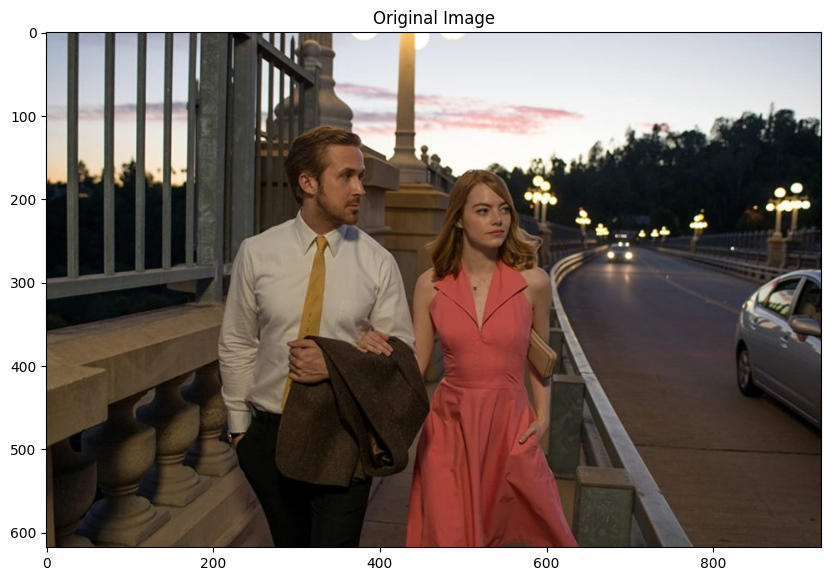

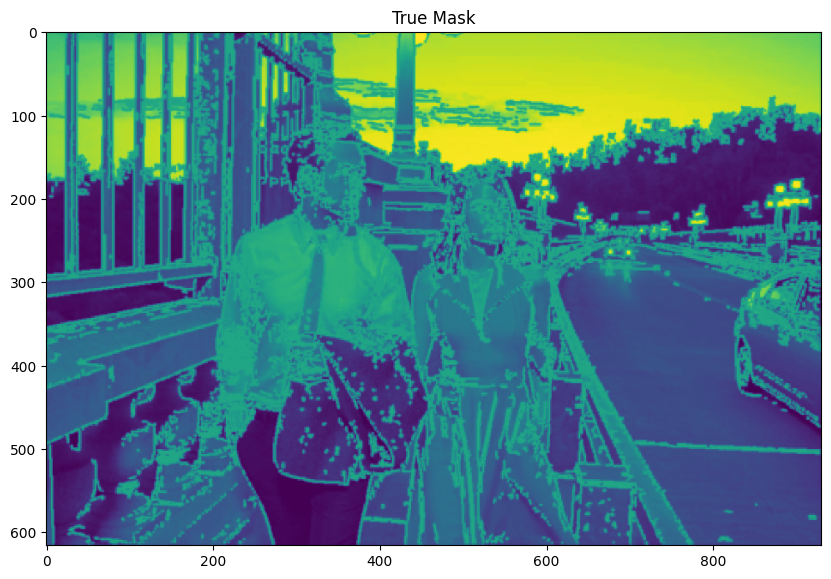

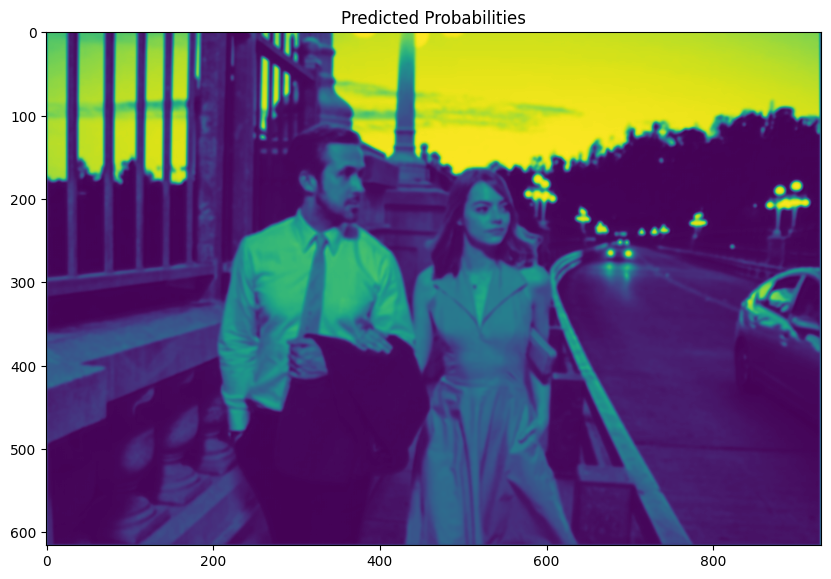

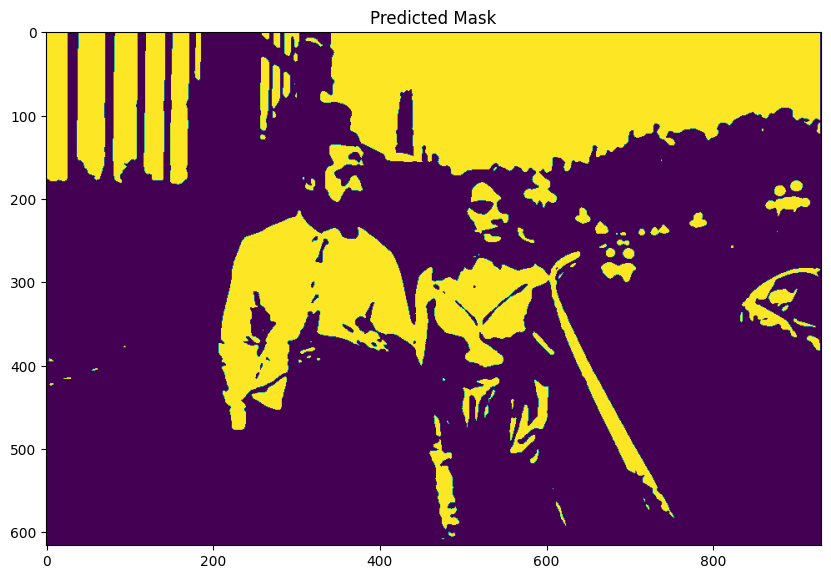

In [31]:
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

for epoch in range(epochs):
    for i, batch in enumerate(train_loader):
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        outputs = resize_tensors(outputs, masks)
        loss = criterion(outputs.to(device), masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

show_image(images, masks, probs, preds)